In [2]:
### import modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Models

## SEIR Model
A basic SEIR model was used to simulate the spread of an infectious disease in a population that was not vaccinated.

### Equations
$$\dot{S} = - \beta S I$$
$$\dot{E}= \beta S I - \sigma E$$
$$\dot{I} = \sigma E - \gamma I$$
$$\dot{R} = \gamma I$$

### Variables
- $S$: Susceptible population
- $E$: Exposed population
- $I$: Infected population
- $R$: Recovered population

### Parameters
- $\beta$: Rate at which infected individuals in class $I$ contact susceptible individuals and infect them
- $\sigma$: Rate at which susceptible individuals in class $S$ progress to the exposed population
- $\gamma$: Rate at which infected individuals in class $I$ recover from the disease and become immune

In [4]:
def seir (y, t, beta, sigma, gamma):    
    s, e, i, r = y
    dsdt = - beta*s*i
    dedt = beta*s*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i
    
    return dsdt, dedt, didt, drdt

## Modified SEIR Model
We modified the above SEIR model to investigate two possible vaccine failure mechanisms - 'leaky' and 'all-or-nothing'.

### Equations
$$\dot{S} = - \beta SI - (1 - \frac{V_{ES} + V_{RS}}{v})fS$$
$$\dot{V}_{ES} = (1 - \epsilon_A)(1 - \frac{V_{ES} + V_{RS}}{v})fS - \beta V_{ES}I$$
$$\dot{V}_{RS} = (1 - \frac{V_{ES} + V_{RS}}{v})fS\epsilon_A - (1-\epsilon_L)\beta V_{RS}I$$
$$\dot{E} = \beta SI + \beta V_{ES}I + (1 - \epsilon_L)\beta V_{RS}I - \sigma E$$
$$\dot{I} = \sigma E - \gamma I$$
$$\dot{R} = \gamma I$$

### Variables
- $S$: Susceptible population
- $V_{ES}$ = Vaccinated population with equal susceptibility
- $V_{RS}$ = Vaccinated population with reduced susceptibility
- $E$: Exposed population
- $I$: Infected population
- $R$: Recovered population

### Parameters
- $\beta$: Rate at which infected individuals in class $I$ contact susceptible individuals and infect them
- $v$: Fraction of population to be vaccinated
- $\epsilon_A$: 'All-or-nothing' vaccine efficacy
- $\epsilon_L$: 'Leaky' vaccine efficacy
- $\sigma$: Rate at which susceptible individuals in class $S$ progress to the exposed population
- $\gamma$: Rate at which infected individuals in class $I$ recover from the disease and become immune

In [7]:
def modified_seir(y, t, beta, sigma, gamma, f, epsL, epsA, v):
    s, v_es, v_rs, e, i, r = y
    dsdt = - beta*s*i - f*(1-(v_es+v_rs)/v)*s
    dvesdt = f*(1-epsA)*(1-(v_es+v_rs)/v)*s - beta*v_es*i
    dvrsdt = f*epsA*(1-(v_es+v_rs)/v)*s - (1-epsL)*beta*v_rs*i
    dedt = beta*s*i + beta*v_es*i + (1-epsL)*beta*v_rs*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i
    return dsdt, dvesdt, dvrsdt, dedt, didt, drdt

# Time-Series Plots

## Pre-transmission Vaccination
We will assume that vaccination happens all at once for simplicity. Note that for a leaky vaccine, $\epsilon_A = 1$, and for an all-or-nothing vaccine, $\epsilon_L = 1$.

For the plots below, $\beta, \gamma, \sigma$ values were chosen based on the characteristics of COVID-19, and $\epsilon_L, \epsilon_A, v$ were arbitrary values that show the difference between the two vaccine failure mechanisms.

In [44]:
### run model
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2*gamma; f = 0; vmax = 0.5
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0; t = np.arange(0, 200)
s0_vax = 0.98-vmax; e0_vax = 0.01; i0_vax = 0.01

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
s, e, i, r = sim.T

# leaky
epsL = 0.5; epsA = 1; 
v_es0_leaky = 0; v_rs0_leaky = vmax; y0_vax_leaky = s0_vax, v_es0_leaky, v_rs0_leaky, e0_vax, i0_vax, r0
sim_leaky = odeint(modified_seir, y0_vax_leaky, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky = sim_leaky.T
vtot_leaky = v_es_leaky + v_rs_leaky

# all-or-nothing
epsL = 1; epsA = 0.5; 
v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA; y0_vax_aon = s0_vax, v_es0_aon, v_rs0_aon, e0_vax, i0_vax, r0
sim_aon = odeint(modified_seir, y0_vax_aon, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon = sim_aon.T
vtot_aon = v_es_aon + v_rs_aon

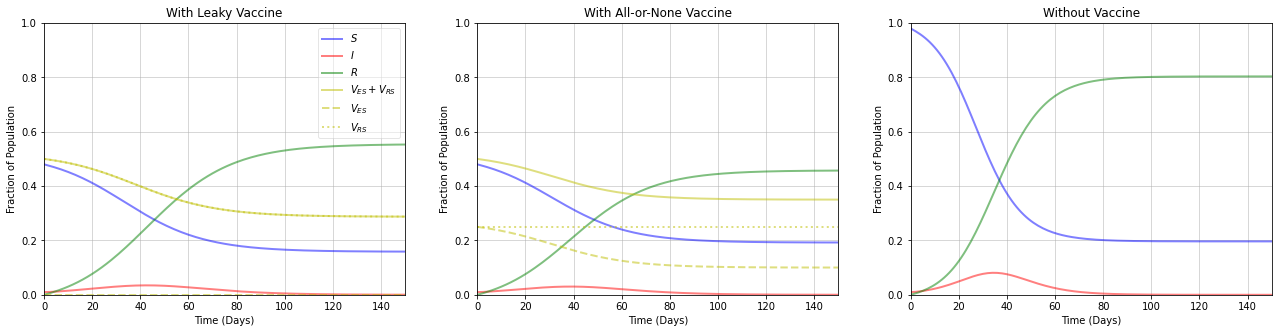

In [45]:
### plot figure
fig = plt.figure(facecolor='w', figsize=(22,5))

ax1 = fig.add_subplot(131, axisbelow=True)
ax1.plot(t, s_leaky, 'b', alpha=0.5, lw=2, label='$S$')
ax1.plot(t, i_leaky, 'r', alpha=0.5, lw=2, label='$I$')
ax1.plot(t, r_leaky, 'g', alpha=0.5, lw=2, label='$R$')
ax1.plot(t, vtot_leaky, 'y', alpha=0.5, lw=2, label='$V_{ES} + V_{RS}$')
ax1.plot(t, v_es_leaky, 'y--', alpha=0.5, lw=2, label='$V_{ES}$')
ax1.plot(t, v_rs_leaky, 'y:', alpha=0.5, lw=2, label='$V_{RS}$')
ax1.set_title("With Leaky Vaccine")
ax1.set_ylim(0, 1); ax1.set_xlim(0, 150)
ax1.set_ylabel("Fraction of Population")
ax1.set_xlabel('Time (Days)')
ax1.grid(linewidth=0.5)
legend = ax1.legend(); legend.get_frame().set_alpha(0.5)

ax2 = fig.add_subplot(132, axisbelow=True)
ax2.plot(t, s_aon, 'b', alpha=0.5, lw=2)
ax2.plot(t, i_aon, 'r', alpha=0.5, lw=2)
ax2.plot(t, r_aon, 'g', alpha=0.5, lw=2)
ax2.plot(t, vtot_aon, 'y', alpha=0.5, lw=2)
ax2.plot(t, v_es_aon, 'y--', alpha=0.5, lw=2)
ax2.plot(t, v_rs_aon, 'y:', alpha=0.5, lw=2)
ax2.set_title("With All-or-None Vaccine")
ax2.set_ylim(0, 1); ax2.set_xlim(0, 150)
ax2.set_ylabel("Fraction of Population")
ax2.set_xlabel('Time (Days)')
ax2.grid(linewidth=0.5)

ax3 = fig.add_subplot(133, axisbelow=True)
ax3.plot(t, s, 'b', alpha=0.5, lw=2)
ax3.plot(t, i, 'r', alpha=0.5, lw=2)
ax3.plot(t, r, 'g', alpha=0.5, lw=2)
ax3.set_title('Without Vaccine')
ax3.set_ylabel('Fraction of Population')
ax3.set_xlabel('Time (Days)')
ax3.set_ylim(0, 1); ax3.set_xlim(0, 150)
ax3.grid(linewidth=0.5)

#plt.savefig('seir_example', bbox_inches='tight')

## 10 Days Post-transmission Vaccination

In [46]:
### run model
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2*gamma; f = 0; vmax = 0.5
s0 = 0.98; v_es0 = 0; v_rs0 = 0; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0; 
D = 150; D_vax = 10; t = np.arange(0, D+1)

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
s, e, i, r = sim.T

# vaccination
t_bfvax = np.arange(0, D_vax+1); t_aftvax = np.arange(D_vax, D+1)
sim_vax = odeint(seir, y0, t_bfvax, args=(beta, sigma, gamma))
s0_vax, e0_vax, i0_vax, r0_vax = sim_vax.T
print(s0_vax[-1])

# leaky
epsL = 0.5; epsA = 1
v_es0_leaky = 0; v_rs0_leaky = vmax
y0_vax_leaky = s0_vax[-1] - vmax, v_es0_leaky, v_rs0_leaky, e0_vax[-1], i0_vax[-1], r0_vax[-1]
sim_leaky = odeint(modified_seir, y0_vax_leaky, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s1_leaky, v_es1_leaky, v_rs1_leaky, e1_leaky, i1_leaky, r1_leaky = sim_leaky.T
vtot1_leaky = v_es1_leaky + v_rs1_leaky

s_leaky = np.concatenate((s0_vax[:-1], s1_leaky), axis=None)
e_leaky = np.concatenate((e0_vax[:-1], e1_leaky), axis=None)
i_leaky = np.concatenate((i0_vax[:-1], i1_leaky), axis=None)
r_leaky = np.concatenate((r0_vax[:-1], r1_leaky), axis=None)
vtot_leaky = np.concatenate((np.zeros(D_vax), vtot1_leaky), axis=None)
v_es_leaky = np.concatenate((np.zeros(D_vax), v_es1_leaky), axis=None)
v_rs_leaky = np.concatenate((np.zeros(D_vax), v_rs1_leaky), axis=None)

# aon
epsL = 1; epsA = 0.5
v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA
y0_vax_aon = s0_vax[-1] - vmax, v_es0_aon, v_rs0_aon, e0_vax[-1], i0_vax[-1], r0_vax[-1]
sim_aon = odeint(modified_seir, y0_vax_aon, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s1_aon, v_es1_aon, v_rs1_aon, e1_aon, i1_aon, r1_aon = sim_aon.T
vtot1_aon = v_es1_aon + v_rs1_aon

s_aon = np.concatenate((s0_vax[:-1], s1_aon), axis=None)
e_aon = np.concatenate((e0_vax[:-1], e1_aon), axis=None)
i_aon = np.concatenate((i0_vax[:-1], i1_aon), axis=None)
r_aon = np.concatenate((r0_vax[:-1], r1_aon), axis=None)
vtot_aon = np.concatenate((np.zeros(D_vax), vtot1_aon), axis=None)
v_es_aon = np.concatenate((np.zeros(D_vax), v_es1_aon), axis=None)
v_rs_aon = np.concatenate((np.zeros(D_vax), v_rs1_aon), axis=None)

0.9103126283600738


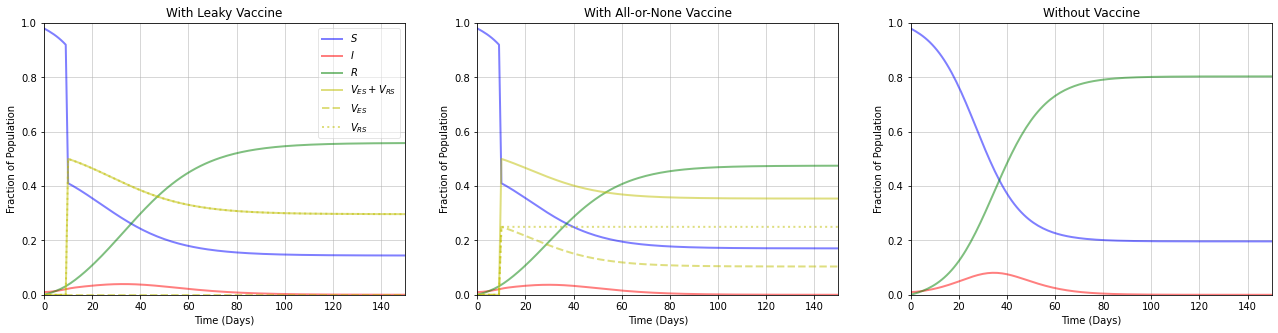

In [47]:
### plot figure
fig = plt.figure(facecolor='w', figsize=(22,5))

ax1 = fig.add_subplot(131, axisbelow=True)
ax1.plot(t, s_leaky, 'b', alpha=0.5, lw=2, label='$S$')
ax1.plot(t, i_leaky, 'r', alpha=0.5, lw=2, label='$I$')
ax1.plot(t, r_leaky, 'g', alpha=0.5, lw=2, label='$R$')
ax1.plot(t, vtot_leaky, 'y', alpha=0.5, lw=2, label='$V_{ES} + V_{RS}$')
ax1.plot(t, v_es_leaky, 'y--', alpha=0.5, lw=2, label='$V_{ES}$')
ax1.plot(t, v_rs_leaky, 'y:', alpha=0.5, lw=2, label='$V_{RS}$')
ax1.set_title("With Leaky Vaccine")
ax1.set_ylim(0, 1); ax1.set_xlim(0, 150)
ax1.set_ylabel("Fraction of Population")
ax1.set_xlabel('Time (Days)')
ax1.grid(linewidth=0.5)
legend = ax1.legend(); legend.get_frame().set_alpha(0.5)

ax2 = fig.add_subplot(132, axisbelow=True)
ax2.plot(t, s_aon, 'b', alpha=0.5, lw=2)
ax2.plot(t, i_aon, 'r', alpha=0.5, lw=2)
ax2.plot(t, r_aon, 'g', alpha=0.5, lw=2)
ax2.plot(t, vtot_aon, 'y', alpha=0.5, lw=2)
ax2.plot(t, v_es_aon, 'y--', alpha=0.5, lw=2)
ax2.plot(t, v_rs_aon, 'y:', alpha=0.5, lw=2)
ax2.set_title("With All-or-None Vaccine")
ax2.set_ylim(0, 1); ax2.set_xlim(0, 150)
ax2.set_ylabel("Fraction of Population")
ax2.set_xlabel('Time (Days)')
ax2.grid(linewidth=0.5)

ax3 = fig.add_subplot(133, axisbelow=True)
ax3.plot(t, s, 'b', alpha=0.5, lw=2)
ax3.plot(t, i, 'r', alpha=0.5, lw=2)
ax3.plot(t, r, 'g', alpha=0.5, lw=2)
ax3.set_title('Without Vaccine')
ax3.set_ylabel('Fraction of Population')
ax3.set_xlabel('Time (Days)')
ax3.set_ylim(0, 1); ax3.set_xlim(0, 150)
ax3.grid(linewidth=0.5)

#plt.savefig('seir_example', bbox_inches='tight')

## 30 Days Post-Transmission Vaccination

In [48]:
### run model
# set parameters
sigma = 1/4; gamma = 1/4; beta = 2*gamma; f = 0; vmax = 0.5
s0 = 0.98; v_es0 = 0; v_rs0 = 0; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0; 
D = 200; D_vax = 30; t = np.arange(0, D+1)

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
s, e, i, r = sim.T

# vaccination
t_bfvax = np.arange(0, D_vax+1); t_aftvax = np.arange(D_vax, D+1)
sim_vax = odeint(seir, y0, t_bfvax, args=(beta, sigma, gamma))
s0_vax, e0_vax, i0_vax, r0_vax = sim_vax.T
print(s0_vax[-1])

# leaky
epsL = 0.5; epsA = 1
v_es0_leaky = 0; v_rs0_leaky = vmax
y0_vax_leaky = s0_vax[-1] - vmax, v_es0_leaky, v_rs0_leaky, e0_vax[-1], i0_vax[-1], r0_vax[-1]
sim_leaky = odeint(modified_seir, y0_vax_leaky, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s1_leaky, v_es1_leaky, v_rs1_leaky, e1_leaky, i1_leaky, r1_leaky = sim_leaky.T
vtot1_leaky = v_es1_leaky + v_rs1_leaky

s_leaky = np.concatenate((s0_vax[:-1], s1_leaky), axis=None)
e_leaky = np.concatenate((e0_vax[:-1], e1_leaky), axis=None)
i_leaky = np.concatenate((i0_vax[:-1], i1_leaky), axis=None)
r_leaky = np.concatenate((r0_vax[:-1], r1_leaky), axis=None)
vtot_leaky = np.concatenate((np.zeros(D_vax), vtot1_leaky), axis=None)
v_es_leaky = np.concatenate((np.zeros(D_vax), v_es1_leaky), axis=None)
v_rs_leaky = np.concatenate((np.zeros(D_vax), v_rs1_leaky), axis=None)

# aon
epsL = 1; epsA = 0.5
v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA
y0_vax_aon = s0_vax[-1] - vmax, v_es0_aon, v_rs0_aon, e0_vax[-1], i0_vax[-1], r0_vax[-1]
sim_aon = odeint(modified_seir, y0_vax_aon, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s1_aon, v_es1_aon, v_rs1_aon, e1_aon, i1_aon, r1_aon = sim_aon.T
vtot1_aon = v_es1_aon + v_rs1_aon

s_aon = np.concatenate((s0_vax[:-1], s1_aon), axis=None)
e_aon = np.concatenate((e0_vax[:-1], e1_aon), axis=None)
i_aon = np.concatenate((i0_vax[:-1], i1_aon), axis=None)
r_aon = np.concatenate((r0_vax[:-1], r1_aon), axis=None)
vtot_aon = np.concatenate((np.zeros(D_vax), vtot1_aon), axis=None)
v_es_aon = np.concatenate((np.zeros(D_vax), v_es1_aon), axis=None)
v_rs_aon = np.concatenate((np.zeros(D_vax), v_rs1_aon), axis=None)

0.5547460665716669


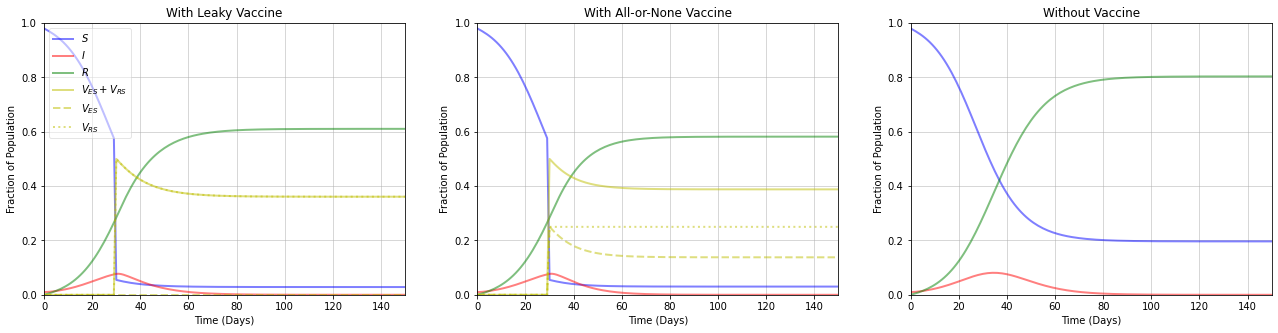

In [49]:
### plot figure
fig = plt.figure(facecolor='w', figsize=(22,5))

ax1 = fig.add_subplot(131, axisbelow=True)
ax1.plot(t, s_leaky, 'b', alpha=0.5, lw=2, label='$S$')
ax1.plot(t, i_leaky, 'r', alpha=0.5, lw=2, label='$I$')
ax1.plot(t, r_leaky, 'g', alpha=0.5, lw=2, label='$R$')
ax1.plot(t, vtot_leaky, 'y', alpha=0.5, lw=2, label='$V_{ES} + V_{RS}$')
ax1.plot(t, v_es_leaky, 'y--', alpha=0.5, lw=2, label='$V_{ES}$')
ax1.plot(t, v_rs_leaky, 'y:', alpha=0.5, lw=2, label='$V_{RS}$')
ax1.set_title("With Leaky Vaccine")
ax1.set_ylim(0, 1); ax1.set_xlim(0, 150)
ax1.set_ylabel("Fraction of Population")
ax1.set_xlabel('Time (Days)')
ax1.grid(linewidth=0.5)
legend = ax1.legend(); legend.get_frame().set_alpha(0.5)

ax2 = fig.add_subplot(132, axisbelow=True)
ax2.plot(t, s_aon, 'b', alpha=0.5, lw=2)
ax2.plot(t, i_aon, 'r', alpha=0.5, lw=2)
ax2.plot(t, r_aon, 'g', alpha=0.5, lw=2)
ax2.plot(t, vtot_aon, 'y', alpha=0.5, lw=2)
ax2.plot(t, v_es_aon, 'y--', alpha=0.5, lw=2)
ax2.plot(t, v_rs_aon, 'y:', alpha=0.5, lw=2)
ax2.set_title("With All-or-None Vaccine")
ax2.set_ylim(0, 1); ax2.set_xlim(0, 150)
ax2.set_ylabel("Fraction of Population")
ax2.set_xlabel('Time (Days)')
ax2.grid(linewidth=0.5)

ax3 = fig.add_subplot(133, axisbelow=True)
ax3.plot(t, s, 'b', alpha=0.5, lw=2)
ax3.plot(t, i, 'r', alpha=0.5, lw=2)
ax3.plot(t, r, 'g', alpha=0.5, lw=2)
ax3.set_title('Without Vaccine')
ax3.set_ylabel('Fraction of Population')
ax3.set_xlabel('Time (Days)')
ax3.set_ylim(0, 1); ax3.set_xlim(0, 150)
ax3.grid(linewidth=0.5)

#plt.savefig('seir_example', bbox_inches='tight')

# Exploring Scenarios

## Pre-transmission Vaccination

In [57]:
### run model for various scenarios
# set parameters
sigma = 1/4; gamma = 1/4; f = 0
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0; 
D = 15000; t = np.arange(0, D+1)

# vary parameters
R0s = np.arange(1.0, 3.0, 0.01); df_R0s = []
epss = np.arange(0.01, 1.0, 0.01); df_epss = []
hits = ['Below HIT', 'Slightly Above HIT', 'Above HIT']; df_vmaxs = []; df_hits = []
df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []; df_sig = []

for R0 in R0s:
    beta = R0 * gamma
    sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
    s, e, i, r = sim.T
    
    for i in range(len(r)//2, len(r)-1):
        if abs(r[i+1] - r[i]) < 0.00000001:
            r_tot = r[i]
            break
            
    for eps in epss:
        hit_val = (1-1/R0)/eps
        for hit in hits:
            if hit == 'Below HIT':
                vmax = hit_val - 0.1
            elif hit == 'Slightly Above HIT':
                vmax = hit_val + 0.07
            else:
                vmax = 0.95

            # leaky
            epsL = eps; epsA = 1
            s0_vax = 0.98-vmax; v_es0_leaky = 0; v_rs0_leaky = vmax
            y0_vax_leaky = s0_vax, v_es0_leaky, v_rs0_leaky, e0, i0, r0
            sim_leaky = odeint(modified_seir, y0_vax_leaky, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky = sim_leaky.T

            for j in range(len(r_leaky)//2, len(r_leaky)-1):
                if abs(r_leaky[j+1] - r_leaky[j]) < 0.00000001:
                    r_tot_leaky = r_leaky[j]
                    break
            r_perc_leaky = abs(r_tot - r_tot_leaky) / r_tot * 100

            # aon
            epsL = 1; epsA = eps
            s0_vax = 0.98-vmax; v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA
            y0_vax_aon = s0_vax, v_es0_aon, v_rs0_aon, e0, i0, r0
            sim_aon = odeint(modified_seir, y0_vax_aon, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon = sim_aon.T

            for k in range(len(r_aon)//2, len(r_aon)-1):
                if abs(r_aon[k+1] - r_aon[k]) < 0.00000001:
                    r_tot_aon = r_aon[k]
                    break
            r_perc_aon = abs(r_tot - r_tot_aon) / r_tot * 100

            r_perc_diff = r_perc_aon - r_perc_leaky
            if r_perc_diff >= 2:
                df_sig.append('Yes')
            else:
                df_sig.append('No')

            df_R0s.append(R0)
            df_epss.append(eps)
            df_vmaxs.append(vmax)
            df_hits.append(hit)
            df_r_perc_leakys.append(r_perc_leaky)
            df_r_perc_aons.append(r_perc_aon)
            df_r_perc_diffs.append(r_perc_diff)

# build dataframe                        
df_timings = ['Pre' for i in df_R0s]

data = {'Vax Timing': df_timings, 'R0': df_R0s, 'VE': df_epss, 'Vax Population': df_hits, 'vmax': df_vmaxs, 'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs, 'Significant': df_sig}
pre_df = pd.DataFrame(data=data)

below_pre_df = pre_df[pre_df['Vax Population'] == 'Below HIT']
slabove_pre_df = pre_df[pre_df['Vax Population'] == 'Slightly Above HIT']
above_pre_df = pre_df[pre_df['Vax Population'] == 'Above HIT']

# reshape data for plotting
pre_plot_R0, pre_plot_VE = np.meshgrid(R0s, epss, indexing='ij')
pre_plot_diff_below = np.reshape(below_pre_df['Diff'].to_numpy(), np.shape(pre_plot_R0))
pre_plot_diff_slabove = np.reshape(slabove_pre_df['Diff'].to_numpy(), np.shape(pre_plot_R0))
pre_plot_diff_above = np.reshape(above_pre_df['Diff'].to_numpy(), np.shape(pre_plot_R0))

In [14]:
print(np.max(pre_plot_diff_slabove))
print(np.max(pre_plot_diff_above))
print(np.max(pre_plot_diff_below))

7.008997155605584
29.045432132197377
25.441249938219137


## 10 Days Post-transmission Vaccination

In [59]:
### run model for various scenarios
# set parameters
sigma = 1/4; gamma = 1/4; f = 0
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0
D = 15000; D_vax = 10; t = np.arange(0, D+1); 
t_bfvax = np.arange(0, D_vax+1); t_aftvax = np.arange(D_vax, D+1)

# vary parameters
R0s = np.arange(1.0, 3.0, 0.01); df_R0s = []
epss = np.arange(0.01, 1.0, 0.01); df_epss = []
hits = ['Below HIT', 'Slightly Above HIT', 'Above HIT']; df_vmaxs = []; df_hits = []
df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []; df_sig = []

for R0 in R0s:
    beta = R0 * gamma
    sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
    s, e, i, r = sim.T
    
    for i in range(len(r)//2, len(r)-1):
        if abs(r[i+1] - r[i]) < 0.00000001:
            r_tot = r[i]
            break
            
    sim_vax = odeint(seir, y0, t_bfvax, args=(beta, sigma, gamma))
    s0_vax, e0_vax, i0_vax, r0_vax = sim_vax.T

    for eps in epss:
        hit_val = (1-1/R0)/eps
        for hit in hits:
            if hit == 'Below HIT':
                vmax = hit_val - 0.1
            elif hit == 'Slightly Above HIT':
                vmax = hit_val + 0.07
            else:
                vmax = 0.95

            # leaky
            epsL = eps; epsA = 1
            v_es0_leaky = 0; v_rs0_leaky = vmax
            y0_vax_leaky = s0_vax[-1] - vmax, v_es0_leaky, v_rs0_leaky, e0_vax[-1], i0_vax[-1], r0_vax[-1]
            sim_leaky = odeint(modified_seir, y0_vax_leaky, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky = sim_leaky.T

            for j in range(len(r_leaky)//2, len(r_leaky)-1):
                if abs(r_leaky[j+1] - r_leaky[j]) < 0.00000001:
                    r_tot_leaky = r_leaky[j]
                    break
            r_perc_leaky = abs(r_tot - r_tot_leaky) / r_tot * 100

            # aon
            epsL = 1; epsA = eps
            v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA
            y0_vax_aon = s0_vax[-1] - vmax, v_es0_aon, v_rs0_aon, e0_vax[-1], i0_vax[-1], r0_vax[-1]
            sim_aon = odeint(modified_seir, y0_vax_aon, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon = sim_aon.T

            for k in range(len(r_aon)//2, len(r_aon)-1):
                if abs(r_aon[k+1] - r_aon[k]) < 0.00000001:
                    r_tot_aon = r_aon[k]
                    break
            r_perc_aon = abs(r_tot - r_tot_aon) / r_tot * 100

            r_perc_diff = r_perc_aon - r_perc_leaky
            if r_perc_diff >= 2:
                df_sig.append('Yes')
            else:
                df_sig.append('No')

            df_R0s.append(R0)
            df_epss.append(eps)
            df_vmaxs.append(vmax)
            df_hits.append(hit)
            df_r_perc_leakys.append(r_perc_leaky)
            df_r_perc_aons.append(r_perc_aon)
            df_r_perc_diffs.append(r_perc_diff)
                        
# build dataframe
df_timings = ['Post 10' for i in df_R0s]

data = {'Vax Timing': df_timings, 'R0': df_R0s, 'VE': df_epss, 'Vax Population': df_hits, 'vmax': df_vmaxs, 'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs, 'Significant': df_sig}
post10_df = pd.DataFrame(data=data)

below_post10_df = post10_df[post10_df['Vax Population'] == 'Below HIT']
slabove_post10_df = post10_df[post10_df['Vax Population'] == 'Slightly Above HIT']
above_post10_df = post10_df[post10_df['Vax Population'] == 'Above HIT']

# reshape data for plotting
post10_plot_R0, post10_plot_VE = np.meshgrid(R0s, epss, indexing='ij')
post10_plot_diff_below = np.reshape(below_post10_df['Diff'].to_numpy(), np.shape(post10_plot_R0))
post10_plot_diff_slabove = np.reshape(slabove_post10_df['Diff'].to_numpy(), np.shape(post10_plot_R0))
post10_plot_diff_above = np.reshape(above_post10_df['Diff'].to_numpy(), np.shape(post10_plot_R0))

## 30 Days Post-transmission Vaccination

In [60]:
### run model for various scenarios
# set parameters
sigma = 1/4; gamma = 1/4; f = 0
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0
D = 15000; D_vax = 30; t = np.arange(0, D+1); 
t_bfvax = np.arange(0, D_vax+1); t_aftvax = np.arange(D_vax, D+1)

# vary parameters
R0s = np.arange(1.0, 3.0, 0.01); df_R0s = []
epss = np.arange(0.01, 1.0, 0.01); df_epss = []
hits = ['Below HIT', 'Slightly Above HIT', 'Above HIT']; df_vmaxs = []; df_hits = []
df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []; df_sig = []

for R0 in R0s:
    beta = R0 * gamma
    sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
    s, e, i, r = sim.T
    
    for i in range(len(r)//2, len(r)-1):
        if abs(r[i+1] - r[i]) < 0.00000001:
            r_tot = r[i]
            break
            
    sim_vax = odeint(seir, y0, t_bfvax, args=(beta, sigma, gamma))
    s0_vax, e0_vax, i0_vax, r0_vax = sim_vax.T

    for eps in epss:
        hit_val = (1-1/R0)/eps
        for hit in hits:
            if hit == 'Below HIT':
                vmax = hit_val - 0.1
            elif hit == 'Slightly Above HIT':
                vmax = hit_val + 0.07
            else:
                vmax = 0.95

            # leaky
            epsL = eps; epsA = 1
            v_es0_leaky = 0; v_rs0_leaky = vmax
            y0_vax_leaky = s0_vax[-1] - vmax, v_es0_leaky, v_rs0_leaky, e0_vax[-1], i0_vax[-1], r0_vax[-1]
            sim_leaky = odeint(modified_seir, y0_vax_leaky, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky = sim_leaky.T

            for j in range(len(r_leaky)//2, len(r_leaky)-1):
                if abs(r_leaky[j+1] - r_leaky[j]) < 0.00000001:
                    r_tot_leaky = r_leaky[j]
                    break
            r_perc_leaky = abs(r_tot - r_tot_leaky) / r_tot * 100

            # aon
            epsL = 1; epsA = eps
            v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA
            y0_vax_aon = s0_vax[-1] - vmax, v_es0_aon, v_rs0_aon, e0_vax[-1], i0_vax[-1], r0_vax[-1]
            sim_aon = odeint(modified_seir, y0_vax_aon, t_aftvax, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
            s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon = sim_aon.T

            for k in range(len(r_aon)//2, len(r_aon)-1):
                if abs(r_aon[k+1] - r_aon[k]) < 0.00000001:
                    r_tot_aon = r_aon[k]
                    break
            r_perc_aon = abs(r_tot - r_tot_aon) / r_tot * 100

            r_perc_diff = r_perc_aon - r_perc_leaky
            if r_perc_diff >= 2:
                df_sig.append('Yes')
            else:
                df_sig.append('No')

            df_R0s.append(R0)
            df_epss.append(eps)
            df_vmaxs.append(vmax)
            df_hits.append(hit)
            df_r_perc_leakys.append(r_perc_leaky)
            df_r_perc_aons.append(r_perc_aon)
            df_r_perc_diffs.append(r_perc_diff)

# build data frame                      
df_timings = ['Post 30' for i in df_R0s]

data = {'Vax Timing': df_timings, 'R0': df_R0s, 'VE': df_epss, 'Vax Population': df_hits, 'vmax': df_vmaxs, 'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs, 'Significant': df_sig}
post30_df = pd.DataFrame(data=data)

below_post30_df = post30_df[post30_df['Vax Population'] == 'Below HIT']
slabove_post30_df = post30_df[post30_df['Vax Population'] == 'Slightly Above HIT']
above_post30_df = post30_df[post30_df['Vax Population'] == 'Above HIT']

# reshape data for plotting
post30_plot_R0, post30_plot_VE = np.meshgrid(R0s, epss, indexing='ij')
post30_plot_diff_below = np.reshape(below_post30_df['Diff'].to_numpy(), np.shape(post30_plot_R0))
post30_plot_diff_slabove = np.reshape(slabove_post30_df['Diff'].to_numpy(), np.shape(post30_plot_R0))
post30_plot_diff_above = np.reshape(above_post30_df['Diff'].to_numpy(), np.shape(post30_plot_R0))

## Results
### 3D Surface Plot

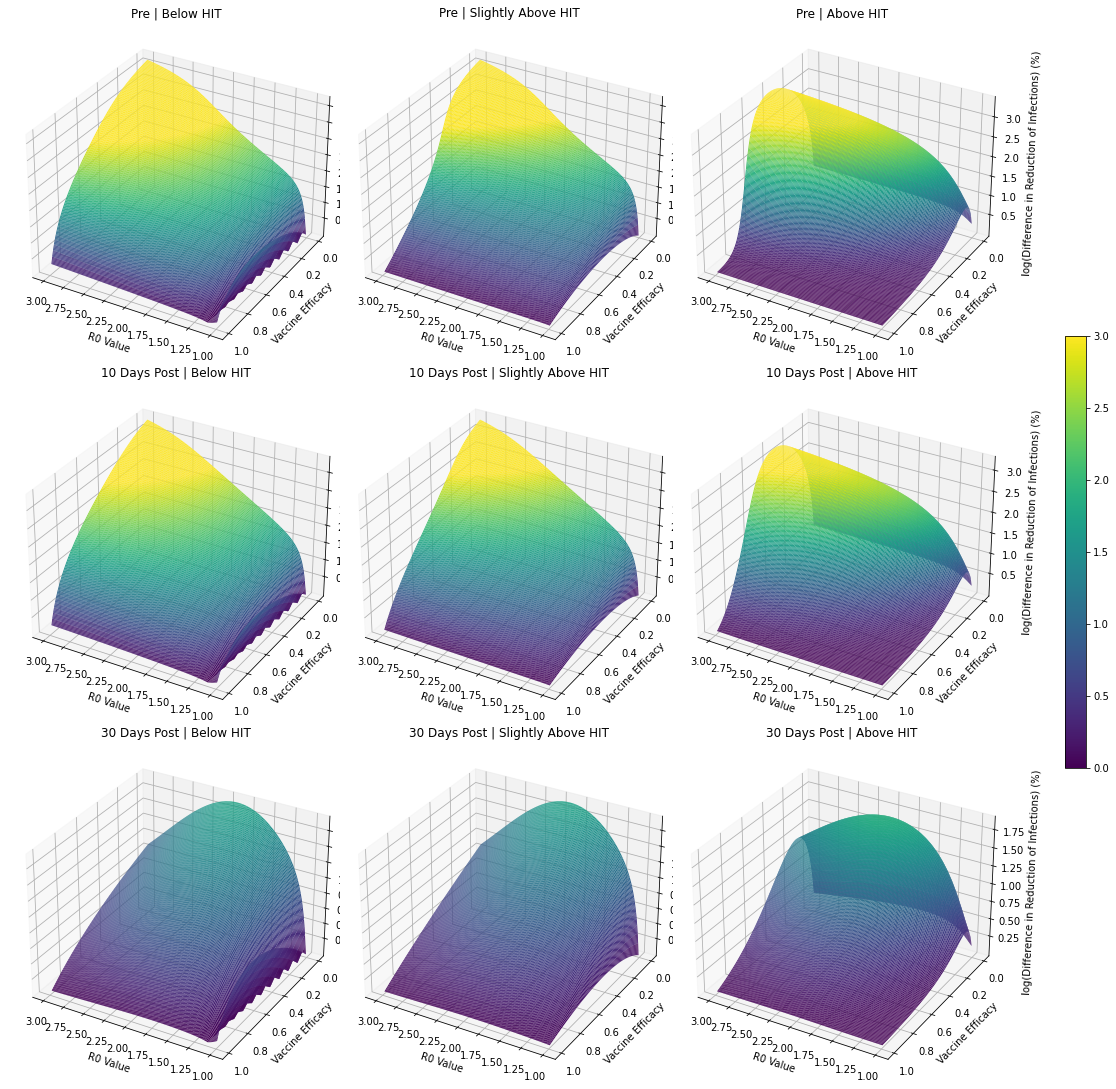

In [66]:
fig, axes = plt.subplots(3,3, facecolor='w', figsize=(15,15), gridspec_kw=dict(width_ratios=[1,1,1]), subplot_kw={'projection': '3d'})

# Pre-transmission
surf1 = axes[0,0].plot_surface(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_below+1), rstride=1, cstride=1, vmin=0, vmax=3, cmap='viridis')
axes[0,0].set_title('Pre | Below HIT')

axes[0,1].plot_surface(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_slabove+1), rstride=1, cstride=1, vmin=0, vmax=3, cmap='viridis')
axes[0,1].set_title('Pre | Slightly Above HIT')

axes[0,2].plot_surface(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_above+1), rstride=1, cstride=1, vmin=0, vmax=3, cmap='viridis')
axes[0,2].set_title('Pre | Above HIT')
axes[0,2].set_zlabel('log(Difference in Reduction of Infections) (%)')


# 10 days post-tranmission
axes[1,0].plot_surface(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_below+1), rstride=1, cstride=1, vmin=0, vmax=3, cmap='viridis')
axes[1,0].set_title('10 Days Post | Below HIT')

axes[1,1].plot_surface(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_slabove+1), rstride=1, cstride=1, vmin=0, vmax=3, cmap='viridis')
axes[1,1].set_title('10 Days Post | Slightly Above HIT')

axes[1,2].plot_surface(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_above+1), rstride=1, cstride=1, vmin=0, vmax=3, cmap='viridis')
axes[1,2].set_title('10 Days Post | Above HIT')
axes[1,2].set_zlabel('log(Difference in Reduction of Infections) (%)')

# 30 days post-transmission
axes[2,0].plot_surface(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_below+1), rstride=1, cstride=1, vmin=0, vmax=3, cmap='viridis')
axes[2,0].set_title('30 Days Post | Below HIT')

axes[2,1].plot_surface(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_slabove+1), rstride=1, cstride=1, vmin=0, vmax=3, cmap='viridis')
axes[2,1].set_title('30 Days Post | Slightly Above HIT')

axes[2,2].plot_surface(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_above+1), rstride=1, cstride=1, vmin=0, vmax=3, cmap='viridis')
axes[2,2].set_title('30 Days Post | Above HIT')
axes[2,2].set_zlabel('log(Difference in Reduction of Infections) (%)')

axs = np.array(axes)
for ax in axs.reshape(-1):
    ax.set_xlabel('R0 Value')
    ax.set_ylabel('Vaccine Efficacy')
    ax.view_init(elev=30, azim=120)

fig.tight_layout(pad=0.05)
cb = fig.colorbar(mappable=surf1, ax=axes, fraction=0.02, shrink=0.5)
#plt.savefig('VE vs R0 Surface Plot', bbox_inches='tight')
plt.show()

### 2D Contour Plot

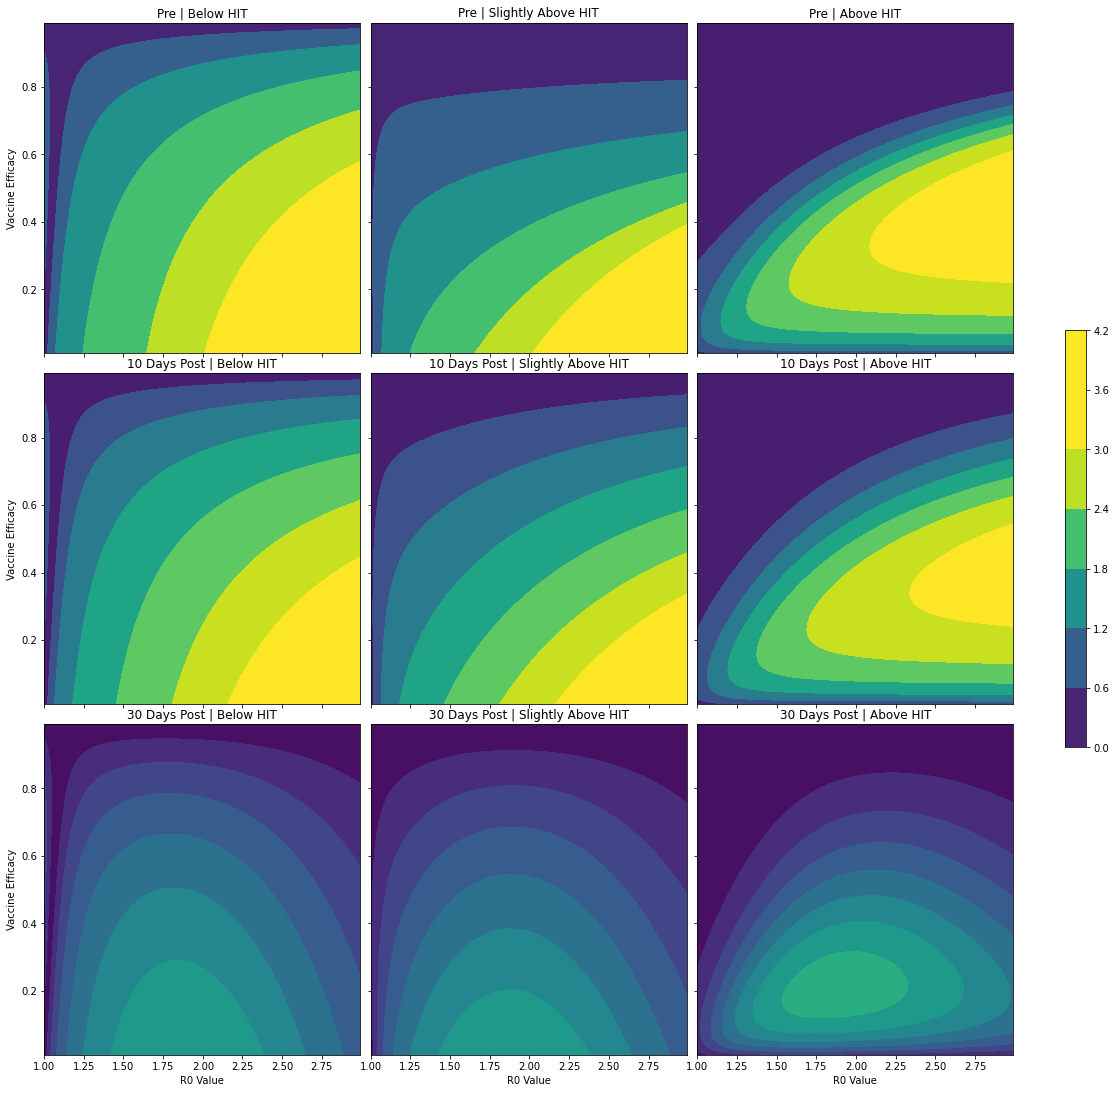

In [67]:
fig, axes = plt.subplots(3,3, facecolor='w', figsize=(15,15), sharex=True, sharey=True, gridspec_kw=dict(width_ratios=[1,1,1]))

# Pre-transmission 
proj = axes[0,0].contourf(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_below+1), vmin=0, vmax=3, cmap='viridis')
axes[0,0].set_title('Pre | Below HIT')
axes[0,0].set_ylabel('Vaccine Efficacy')

axes[0,1].contourf(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_slabove+1), vmin=0, vmax=3, cmap='viridis')
axes[0,1].set_title('Pre | Slightly Above HIT')

#ax3 = fig.add_subplot(133)
axes[0,2].contourf(pre_plot_R0, pre_plot_VE, np.log(pre_plot_diff_above+1), vmin=0, vmax=3, cmap='viridis')
axes[0,2].set_title('Pre | Above HIT')

# 10 days post-transmission
axes[1,0].contourf(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_below+1), vmin=0, vmax=3, cmap='viridis')
axes[1,0].set_title('10 Days Post | Below HIT')
axes[1,0].set_ylabel('Vaccine Efficacy')

axes[1,1].contourf(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_slabove+1), vmin=0, vmax=3, cmap='viridis')
axes[1,1].set_title('10 Days Post | Slightly Above HIT')

axes[1,2].contourf(post10_plot_R0, post10_plot_VE, np.log(post10_plot_diff_above+1), vmin=0, vmax=3, cmap='viridis')
axes[1,2].set_title('10 Days Post | Above HIT')

# 30 days post-transmission
axes[2,0].contourf(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_below+1), vmin=0, vmax=3, cmap='viridis')
axes[2,0].set_title('30 Days Post | Below HIT')
axes[2,0].set_ylabel('Vaccine Efficacy')
axes[2,0].set_xlabel('R0 Value')

axes[2,1].contourf(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_slabove+1), vmin=0, vmax=3, cmap='viridis')
axes[2,1].set_title('30 Days Post | Slightly Above HIT')
axes[2,1].set_xlabel('R0 Value')

axes[2,2].contourf(post30_plot_R0, post30_plot_VE, np.log(post30_plot_diff_above+1), vmin=0, vmax=3, cmap='viridis')
axes[2,2].set_title('30 Days Post | Above HIT')
axes[2,2].set_xlabel('R0 Value')

fig.tight_layout(pad=0.05)
cb = fig.colorbar(mappable=proj, ax=axes, fraction=0.02, shrink=0.5)
#plt.savefig('VE vs R0 2D Contour Plot', bbox_inches='tight')
plt.show()